In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
import math

In [2]:
# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load embeddings
with open('../data/embeddings.pkl', 'rb') as f:
    data = pickle.load(f)

X_train_emb = data['X_train_emb']
X_val_emb = data['X_val_emb']
X_test_emb = data['X_test_emb']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']
label_encoder = data['label_encoder']
embedding_dim = data['embedding_dim']

print(f"Embedding dim: {embedding_dim}")
print(f"Classes: {label_encoder.classes_.tolist()}")

Using device: cpu
Embedding dim: 384
Classes: ['ADHD', 'OCD', 'aspergers', 'depression', 'ptsd']


In [3]:
class TimelineDataset(Dataset):
    def __init__(self, embeddings, labels, max_len=50):
        self.embeddings = embeddings
        self.labels = labels
        self.max_len = max_len
    
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        emb = self.embeddings[idx]
        label = self.labels[idx]
        
        seq_len = len(emb)
        
        if seq_len > self.max_len:
            emb = emb[:self.max_len]
            seq_len = self.max_len
        
        if seq_len < self.max_len:
            padding = np.zeros((self.max_len - seq_len, emb.shape[1]))
            emb = np.vstack([emb, padding])
        
        return {
            'embedding': torch.FloatTensor(emb),
            'label': torch.LongTensor([label])[0],
            'seq_len': seq_len
        }

MAX_LEN = 50
BATCH_SIZE = 32

train_dataset = TimelineDataset(X_train_emb, y_train, max_len=MAX_LEN)
val_dataset = TimelineDataset(X_val_emb, y_val, max_len=MAX_LEN)
test_dataset = TimelineDataset(X_test_emb, y_test, max_len=MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Data loaders created: {len(train_loader)} train batches")

Data loaders created: 56 train batches


In [ ]:
class PositionalEncoding(nn.Module):
    """
    Adds positional information to embeddings.
    This tells the Transformer the ORDER of posts in the timeline.
    """
    
    def __init__(self, d_model, max_len=50, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        """
        Args:
            x: (batch_size, seq_len, d_model)
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

print("Positional Encoding defined!")

Positional Encoding defined!


In [ ]:
class TransformerClassifier(nn.Module):
    """
    Transformer Encoder for timeline classification.
    
    Architecture:
    1. Positional encoding adds temporal information
    2. Transformer encoder learns relationships between posts
    3. CLS token aggregates sequence information
    4. Classifier predicts mental health category
    """
    
    def __init__(self, input_dim, num_classes, num_heads=4, num_layers=2, 
                 hidden_dim=256, dropout=0.1, max_len=50):
        super(TransformerClassifier, self).__init__()
        
        self.input_dim = input_dim
        
        # CLS token (learnable)
        self.cls_token = nn.Parameter(torch.randn(1, 1, input_dim))
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(input_dim, max_len + 1, dropout)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
        
        # Store for ablation
        self.use_positional = True
    
    def forward(self, x, seq_lens=None):
        """
        Args:
            x: (batch_size, seq_len, input_dim)
            seq_lens: actual sequence lengths
        
        Returns:
            logits: (batch_size, num_classes)
        """
        batch_size, seq_len, _ = x.shape
        
        # CLS token at the beginning
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)  # (batch, seq_len+1, input_dim)
        
        # positional encoding
        if self.use_positional:
            x = self.pos_encoder(x)
        
        # attention mask for padding
        if seq_lens is not None:
            # Mask shape: (batch, seq_len+1)
            max_len = seq_len + 1  # +1 for CLS token
            mask = torch.zeros(batch_size, max_len, device=x.device)
            for i, length in enumerate(seq_lens):
                mask[i, length + 1:] = 1  # +1 because CLS is at position 0
            mask = mask.bool()
        else:
            mask = None
        
        # Transformer encoder
        x = self.transformer(x, src_key_padding_mask=mask)
        
        # CLS token output for classification
        cls_output = x[:, 0, :]  # (batch, input_dim)
        
        # Classify
        logits = self.classifier(cls_output)
        
        return logits

# model
NUM_CLASSES = len(label_encoder.classes_)

model = TransformerClassifier(
    input_dim=embedding_dim,
    num_classes=NUM_CLASSES,
    num_heads=4,
    num_layers=2,
    hidden_dim=256,
    dropout=0.1,
    max_len=MAX_LEN
).to(device)

print("Model architecture:")
print(model)
print()
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Model architecture:
TransformerClassifier(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
        )
        (linear1): Linear(in_features=384, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=384, bias=True)
        (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=384, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(i

In [6]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch in train_loader:
        embeddings = batch['embedding'].to(device)
        labels = batch['label'].to(device)
        seq_lens = batch['seq_len'].to(device)
        
        optimizer.zero_grad()
        logits = model(embeddings, seq_lens)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    return avg_loss, accuracy, f1

def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            embeddings = batch['embedding'].to(device)
            labels = batch['label'].to(device)
            seq_lens = batch['seq_len'].to(device)
            
            logits = model(embeddings, seq_lens)
            loss = criterion(logits, labels)
            
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    return avg_loss, accuracy, f1, all_preds, all_labels

print("Training functions defined!")

Training functions defined!


In [7]:
NUM_EPOCHS = 30
LEARNING_RATE = 0.0005  # Lower learning rate for Transformer

# Class weights
class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_counts)
class_weights = torch.FloatTensor(class_weights).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training history
history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_f1': []
}

best_val_f1 = 0
best_model_state = None

print("Training Transformer Model")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc, train_f1 = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_state = model.state_dict().copy()
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:2d}/{NUM_EPOCHS}: "
              f"Train Loss={train_loss:.4f}, Acc={train_acc:.4f}, F1={train_f1:.4f} | "
              f"Val Loss={val_loss:.4f}, Acc={val_acc:.4f}, F1={val_f1:.4f}")

print()
print(f"Best Val F1: {best_val_f1:.4f}")

model.load_state_dict(best_model_state)
print("✓ Loaded best model")

Training Transformer Model


/Users/rutujashingate/Desktop/mental-heatlh-detection/venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Epoch  1/30: Train Loss=1.6426, Acc=0.2073, F1=0.1955 | Val Loss=1.6139, Acc=0.1406, F1=0.0493
Epoch  5/30: Train Loss=1.4634, Acc=0.3486, F1=0.3387 | Val Loss=1.3235, Acc=0.3750, F1=0.3496
Epoch 10/30: Train Loss=0.5940, Acc=0.7994, F1=0.7744 | Val Loss=0.4363, Acc=0.8854, F1=0.8703
Epoch 15/30: Train Loss=0.4356, Acc=0.8821, F1=0.8546 | Val Loss=0.3528, Acc=0.8906, F1=0.8748
Epoch 20/30: Train Loss=0.3541, Acc=0.8939, F1=0.8731 | Val Loss=0.3303, Acc=0.9036, F1=0.8824
Epoch 25/30: Train Loss=0.3446, Acc=0.8994, F1=0.8783 | Val Loss=0.2817, Acc=0.9219, F1=0.9115
Epoch 30/30: Train Loss=0.3143, Acc=0.9028, F1=0.8818 | Val Loss=0.2492, Acc=0.9167, F1=0.8968

Best Val F1: 0.9229
✓ Loaded best model


In [8]:
test_loss, test_acc, test_f1, test_preds, test_labels = evaluate(
    model, test_loader, criterion, device
)

print("=" * 60)
print("TRANSFORMER TEST RESULTS")
print("=" * 60)
print(f"Accuracy: {test_acc:.4f} ({test_acc*100:.1f}%)")
print(f"F1 (macro): {test_f1:.4f}")
print()
print("Classification Report:")
print("-" * 60)
print(classification_report(
    test_labels, 
    test_preds, 
    target_names=label_encoder.classes_
))

TRANSFORMER TEST RESULTS
Accuracy: 0.9115 (91.1%)
F1 (macro): 0.8932

Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

        ADHD       0.92      0.96      0.94        69
         OCD       0.99      0.90      0.95       144
   aspergers       0.93      0.91      0.92        85
  depression       0.70      0.97      0.82        32
        ptsd       0.85      0.85      0.85        54

    accuracy                           0.91       384
   macro avg       0.88      0.92      0.89       384
weighted avg       0.92      0.91      0.91       384



In [9]:
def evaluate_early_detection_transformer(model, X_emb, y_true, device, percentages=[0.25, 0.50, 0.75, 1.0]):
    """Evaluate Transformer using only first X% of each user's timeline."""
    model.eval()
    results = {}
    
    for pct in percentages:
        all_preds = []
        
        with torch.no_grad():
            for timeline in X_emb:
                num_posts = max(1, int(len(timeline) * pct))
                truncated = timeline[:num_posts]
                
                max_len = 50
                seq_len = len(truncated)
                if seq_len < max_len:
                    padding = np.zeros((max_len - seq_len, truncated.shape[1]))
                    truncated = np.vstack([truncated, padding])
                
                x = torch.FloatTensor(truncated).unsqueeze(0).to(device)
                seq_lens = torch.LongTensor([seq_len]).to(device)
                
                logits = model(x, seq_lens)
                pred = torch.argmax(logits, dim=1).cpu().numpy()[0]
                all_preds.append(pred)
        
        acc = accuracy_score(y_true, all_preds)
        f1 = f1_score(y_true, all_preds, average='macro')
        avg_posts = np.mean([max(1, int(len(t) * pct)) for t in X_emb])
        
        results[pct] = {
            'accuracy': acc,
            'f1_macro': f1,
            'avg_posts_used': avg_posts
        }
        
        print(f"{int(pct*100):3d}% history: Accuracy={acc:.4f}, F1={f1:.4f}, Avg posts={avg_posts:.1f}")
    
    return results

print("Early Detection Results - Transformer (Test Set)")
print("=" * 60)
transformer_early_results = evaluate_early_detection_transformer(model, X_test_emb, y_test, device)

Early Detection Results - Transformer (Test Set)
 25% history: Accuracy=0.7474, F1=0.7257, Avg posts=2.0
 50% history: Accuracy=0.8698, F1=0.8502, Avg posts=4.4
 75% history: Accuracy=0.9271, F1=0.9131, Avg posts=6.5
100% history: Accuracy=0.9115, F1=0.8932, Avg posts=9.4


In [10]:
# Load baseline and BiLSTM results
with open('../results/baseline_results.pkl', 'rb') as f:
    baseline_data = pickle.load(f)
baseline_early = baseline_data['early_detection']

with open('../results/bilstm_results.pkl', 'rb') as f:
    bilstm_data = pickle.load(f)
bilstm_early = bilstm_data['early_detection']

# Print comparison table
print("\n" + "=" * 80)
print("EARLY DETECTION COMPARISON: All Models")
print("=" * 80)
print(f"{'History':<10} {'Baseline':<15} {'BiLSTM':<15} {'Transformer':<15} {'Best Model':<15}")
print("-" * 80)

for pct in [0.25, 0.50, 0.75, 1.0]:
    base_acc = baseline_early[pct]['accuracy'] * 100
    bilstm_acc = bilstm_early[pct]['accuracy'] * 100
    trans_acc = transformer_early_results[pct]['accuracy'] * 100
    
    # Find best
    accs = {'Baseline': base_acc, 'BiLSTM': bilstm_acc, 'Transformer': trans_acc}
    best = max(accs, key=accs.get)
    
    print(f"{int(pct*100):3d}%       {base_acc:>6.1f}%         {bilstm_acc:>6.1f}%         {trans_acc:>6.1f}%         {best}")

print("-" * 80)


EARLY DETECTION COMPARISON: All Models
History    Baseline        BiLSTM          Transformer     Best Model     
--------------------------------------------------------------------------------
 25%         84.1%           81.2%           74.7%         Baseline
 50%         92.4%           91.1%           87.0%         Baseline
 75%         91.7%           93.8%           92.7%         BiLSTM
100%         93.0%           93.8%           91.1%         BiLSTM
--------------------------------------------------------------------------------


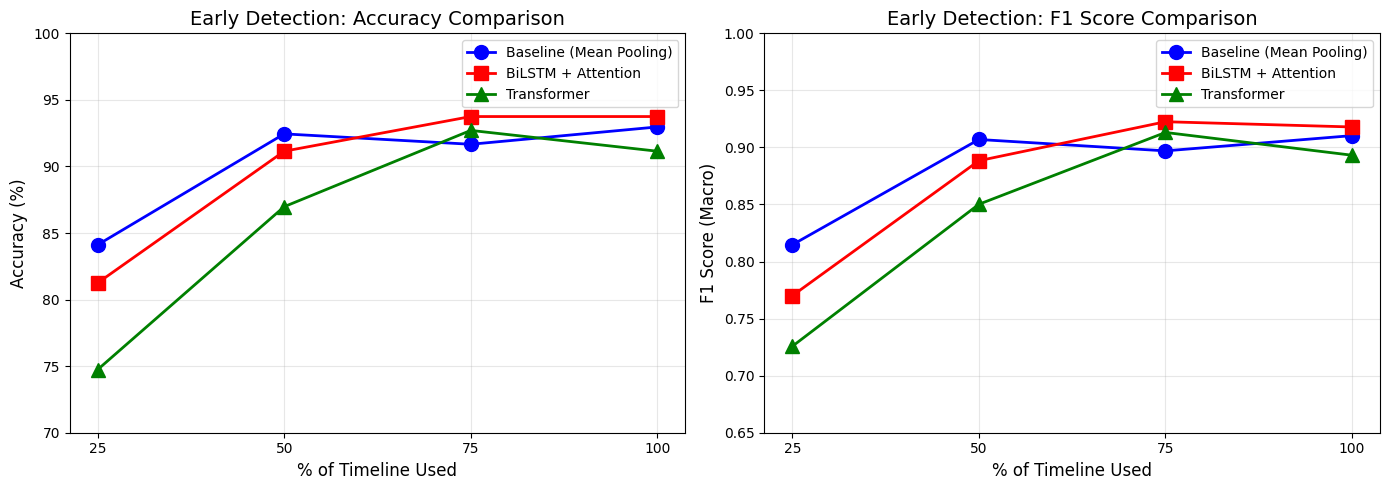

✓ Saved to results/all_models_comparison.png


In [11]:
percentages = [0.25, 0.50, 0.75, 1.0]

baseline_accs = [baseline_early[p]['accuracy'] * 100 for p in percentages]
bilstm_accs = [bilstm_early[p]['accuracy'] * 100 for p in percentages]
transformer_accs = [transformer_early_results[p]['accuracy'] * 100 for p in percentages]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = [25, 50, 75, 100]

# Accuracy comparison
axes[0].plot(x, baseline_accs, 'b-o', label='Baseline (Mean Pooling)', linewidth=2, markersize=10)
axes[0].plot(x, bilstm_accs, 'r-s', label='BiLSTM + Attention', linewidth=2, markersize=10)
axes[0].plot(x, transformer_accs, 'g-^', label='Transformer', linewidth=2, markersize=10)
axes[0].set_xlabel('% of Timeline Used', fontsize=12)
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Early Detection: Accuracy Comparison', fontsize=14)
axes[0].legend(fontsize=10)
axes[0].set_xticks(x)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([70, 100])

# F1 comparison
baseline_f1s = [baseline_early[p]['f1_macro'] for p in percentages]
bilstm_f1s = [bilstm_early[p]['f1_macro'] for p in percentages]
transformer_f1s = [transformer_early_results[p]['f1_macro'] for p in percentages]

axes[1].plot(x, baseline_f1s, 'b-o', label='Baseline (Mean Pooling)', linewidth=2, markersize=10)
axes[1].plot(x, bilstm_f1s, 'r-s', label='BiLSTM + Attention', linewidth=2, markersize=10)
axes[1].plot(x, transformer_f1s, 'g-^', label='Transformer', linewidth=2, markersize=10)
axes[1].set_xlabel('% of Timeline Used', fontsize=12)
axes[1].set_ylabel('F1 Score (Macro)', fontsize=12)
axes[1].set_title('Early Detection: F1 Score Comparison', fontsize=14)
axes[1].legend(fontsize=10)
axes[1].set_xticks(x)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0.65, 1.0])

plt.tight_layout()
plt.savefig('../results/all_models_comparison.png', dpi=150)
plt.show()

print("✓ Saved to results/all_models_comparison.png")

In [12]:
torch.save(model.state_dict(), '../results/transformer_model.pth')

transformer_results = {
    'model_name': 'Transformer',
    'test_accuracy': test_acc,
    'test_f1': test_f1,
    'early_detection': transformer_early_results,
    'history': history
}

with open('../results/transformer_results.pkl', 'wb') as f:
    pickle.dump(transformer_results, f)

print("✓ Saved model and results")

✓ Saved model and results
